<a href="https://colab.research.google.com/github/gaellequillaud/Molecular_Property_Prediction_GNN/blob/main/Molecular_Property_Prediction_GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Molecular Property Prediction Using Graph Neural Networks**


## **1. Install RDkit and PyTorch Geometric**



In [2]:
! pip install rdkit
! pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 50.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.1 MB/s eta 0:00:00


---

## **2. Solubility dataset**

The original [Delaney's dataset](https://pubs.acs.org/doi/suppl/10.1021/ci034243x/suppl_file/ci034243xsi20040112_053635.txt). The full paper is entitled [ESOL:  Estimating Aqueous Solubility Directly from Molecular Structure](https://pubs.acs.org/doi/10.1021/ci034243x).$^1$

### **2.1. Download the dataset**

In [3]:
! wget https://pubs.acs.org/doi/suppl/10.1021/ci034243x/suppl_file/ci034243xsi20040112_053635.txt

--2024-04-14 19:47:53--  https://pubs.acs.org/doi/suppl/10.1021/ci034243x/suppl_file/ci034243xsi20040112_053635.txt
Resolving pubs.acs.org (pubs.acs.org)... 172.64.153.22, 104.18.34.234
Connecting to pubs.acs.org (pubs.acs.org)|172.64.153.22|:443... connected.
HTTP request sent, awaiting response... 403 Forbidden
2024-04-14 19:47:53 ERROR 403: Forbidden.



If the previous link doesn't work, use :

In [4]:
! wget https://raw.githubusercontent.com/gaellequillaud/Molecular_Property_Prediction_GNN/main/delaney.csv

--2024-04-14 19:47:53--  https://raw.githubusercontent.com/gaellequillaud/Molecular_Property_Prediction_GNN/main/delaney.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58888 (58K) [text/plain]
Saving to: ‘delaney.csv’

delaney.csv         100%[===================>]  57.51K  --.-KB/s    in 0.001s  

2024-04-14 19:47:53 (55.0 MB/s) - ‘delaney.csv’ saved [58888/58888]



### **2.2. Read in the dataset**

In [5]:
import pandas as pd

In [6]:
sol = pd.read_csv('delaney.csv')
sol

,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES
0,"1,1,1,2-Tetrachloroethane",-2.180,-2.794,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.000,-2.232,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.740,-2.549,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.480,-1.961,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.040,-3.077,FC(F)(Cl)C(F)(Cl)Cl
...,...,...,...,...
1139,vamidothion,1.144,-1.446,CNC(=O)C(C)SCCSP(=O)(OC)(OC)
1140,Vinclozolin,-4.925,-4.377,CC1(OC(=O)N(C1=O)c2cc(Cl)cc(Cl)c2)C=C
1141,Warfarin,-3.893,-3.913,CC(=O)CC(c1ccccc1)c3c(O)c2ccccc2oc3=O
1142,Xipamide,-3.790,-3.642,Cc1cccc(C)c1NC(=O)c2cc(c(Cl)cc2O)S(N)(=O)=O


In [7]:
smiles_list = [smiles for smiles in sol.SMILES]

Extract atom symbols from the datset

In [8]:
import re

In [9]:
atom_symbols = set()
for compound in smiles_list:
    symbols = re.findall('[A-Z][a-z]?', compound)
    atom_symbols.update(symbols)

atom_symbols_list = list(atom_symbols)

In [10]:
atom_symbols_list

['N',
 'Oc',
 'S',
 'I',
 'Cn',
 'Ic',
 'H',
 'F',
 'Cc',
 'Br',
 'Fc',
 'Cl',
 'C',
 'Nc',
 'O',
 'P',
 'Sc']

---

## **3. Imports**

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os

from rdkit import Chem
from rdkit.Chem import MolFromSmiles, rdmolops

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data, DataLoader
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv
from torch_geometric.nn.dense import DenseGCNConv
from torch_geometric.nn import global_max_pool as gmp

import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm.notebook import tqdm
from scipy.sparse import coo_matrix

## **4. Data preparation**

### **4.1. Atom and edge features**

In [12]:
def atom_features(mol):
  symbols = [
    'Oc', 'I', 'H', 'Sc', 'Cc', 'C', 'Fc', 'Cl', 'Nc', 'Cn', 'S', 'P', 'Ic',
    'O', 'Br', 'N', 'F'
  ]

  hybridizations = [
    Chem.rdchem.HybridizationType.S,
    Chem.rdchem.HybridizationType.SP,
    Chem.rdchem.HybridizationType.SP2,
    Chem.rdchem.HybridizationType.SP3,
    Chem.rdchem.HybridizationType.SP3D,
    Chem.rdchem.HybridizationType.SP3D2,
    'other',
  ]

  XS = []
  features = []

  for atom in mol.GetAtoms():
    # Symbol feature
    symbol = [0.]*len(symbols)
    symbol[symbols.index(atom.GetSymbol())] = 1.

    # Degree feature
    degree = [0.]*8
    degree[atom.GetDegree()]=1.

    # Charge feature
    charge = atom.GetFormalCharge()

    # Radical electrons feature??
    radical_electrons = atom.GetNumRadicalElectrons()

    # Hybridization feature
    hybridization = [0.]*len(hybridizations)
    hybridization[hybridizations.index(atom.GetHybridization())]=1.

    # Aromaticity feature
    if atom.GetIsAromatic():
      aromaticity = 1.
    else:
      aromaticity = 0.

    # Number of connected hydrogens feature
    hydrogens = [0.]*5
    hydrogens[atom.GetTotalNumHs()]=1.

    # Chirality feature
    if atom.HasProp('_ChiralityPossible'):
      chirality = 1.
    else:
      chirality = 0.

    chirality_type = [0.]*2
    if atom.HasProp('_CIPCode'):
      chirality_type[['R', 'S'].index(atom.GetProp('_CIPCode'))]=1.
      print(chirality_type)

    X = torch.tensor(symbol + degree + [charge] + [radical_electrons] +
                     hybridization + [aromaticity] + hydrogens + [chirality] +
                     chirality_type)
    XS.append(X)
    features = torch.stack(XS, dim=0)

  return features

In [13]:
def edge_features(mol):
  stereos = [
    Chem.rdchem.BondStereo.STEREONONE,
    Chem.rdchem.BondStereo.STEREOANY,
    Chem.rdchem.BondStereo.STEREOZ,
    Chem.rdchem.BondStereo.STEREOE,
  ]

  edge_indices = []
  edge_attrs = []

  for bond in mol.GetBonds():
    edge_indices += [[bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()]]
    edge_indices += [[bond.GetEndAtomIdx(), bond.GetBeginAtomIdx()]]

    # Bond type feature
    bond_type = bond.GetBondType()
    single = 1. if bond_type == Chem.rdchem.BondType.SINGLE else 0.
    double = 1. if bond_type == Chem.rdchem.BondType.DOUBLE else 0.
    triple = 1. if bond_type == Chem.rdchem.BondType.TRIPLE else 0.
    aromatic = 1. if bond_type == Chem.rdchem.BondType.AROMATIC else 0.

    # Conjugation feature
    conjugation = 1. if bond.GetIsConjugated() else 0.

    # Stereo feature
    stereo = [0.]*len(stereos)
    stereo[stereos.index(bond.GetStereo())] = 1.

    # Ring membership feature
    ring_membership = 1. if bond.IsInRing() else 0.


    edge_attr = torch.tensor([single, double, triple, aromatic, conjugation,
                                  ring_membership] + stereo)
    edge_attrs += [edge_attr, edge_attr]

  if len(edge_attrs) == 0:
    edge_index = torch.zeros((2,0), dtype=torch.long)
    edge_attr = torch.zeros((0,10), dtype=torch.float)
  else:
    edge_index = torch.tensor(edge_indices).t().contiguous()
    edge_attr =  torch.stack(edge_attrs, dim=0)

  return edge_index, edge_attr



### **4.2. Conversion to a graph**

In [14]:
def smiles_to_graph(smiles):
  mol = Chem.MolFromSmiles(smiles)
  if mol==None:
    return None

  ## Atom features
  features = atom_features(mol)

  ## Edge features
  edge_index, edge_attr = edge_features(mol)

  nb_atoms = mol.GetNumAtoms()
  adjacency_matrix = rdmolops.GetAdjacencyMatrix(mol, useBO=True)

  return nb_atoms, features, edge_index, edge_attr, adjacency_matrix

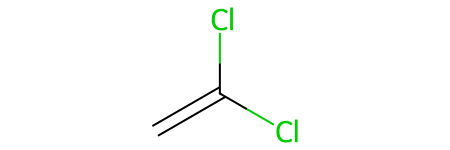

In [15]:
Chem.MolFromSmiles('ClC(=C)Cl')

In [16]:
# smiles_to_graph('ClC(=C)Cl')

In [17]:
graph_data = []
targets = []

for idx, row in sol.iterrows():
    smiles = row['SMILES']
    solubility = row['measured log(solubility:mol/L)']
    graph = smiles_to_graph(smiles)
    if graph is not None:
        nb_atoms, features, edge_index, edge_attr, adjacency_matrix = graph
        graph_data.append(Data(x=features, edge_index=edge_index, edge_attr=edge_attr))
        targets.append(solubility)

In [18]:
# Convert targets to tensor
targets = torch.tensor(targets, dtype=torch.float32)

## **5. Graph Convolutional Neural Network**

### **5.1. Split data into training and testing**

In [19]:
train_data, test_data, train_targets, test_targets = train_test_split(graph_data, targets, test_size=0.2, random_state=42)

### **5.2. Define the model**

In [22]:
class GCN(nn.Module):
  def __init__(self, num_features=43, dropout=0.2):
    super(GCN, self).__init__()

    self.conv1 = GCNConv(num_features, 336)
    self.conv2 = GCNConv(336, 168)
    self.lin1 = nn.Linear(168, 84)
    self.lin2 = nn.Linear(84, 42)
    self.out = nn.Linear(42, 1)

    self.dropout = nn.Dropout(dropout)

  def forward(self, data):
    x, edge_index = data.x, data.edge_index

    x = F.relu(self.conv1(x, edge_index))
    x = F.dropout(x, p=0.2, training=self.training)
    x = self.conv2(x, edge_index)
    x = F.relu(x)
    x = gmp(x, batch=data.batch)
    x = self.lin1(x)
    x = F.relu(x)

    x = self.lin2(x)
    x = F.relu(x)
    x = self.out(x)

    return x

### **5.3. Initialize the model**

In [27]:
model = GCN(num_features=43)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

### **5.4. Train the model**

In [44]:
from tqdm import tqdm

# 3.4. Train the model

num_epochs = 100
train_losses = []

for epoch in range(num_epochs):
  model.train()
  epoch_loss = 0.0
  with tqdm(total=len(train_data), desc=f"Epoch {epoch+1}/{num_epochs}", unit='data') as pbar:
      for data, target in zip(train_data, train_targets):
        # Move data and target to GPU
        data = data.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        outputs = model(data)

        # Ensure target tensor has the same size as outputs
        if target.dim() == 0:
          target = target.expand_as(outputs)

        mse_loss = F.mse_loss(outputs, target)  # Use torch.nn.functional.mse_loss
        mae_loss = F.l1_loss(outputs, target)
        mse_loss.backward()
        # mae_loss.backward()
        optimizer.step()

        epoch_loss += mse_loss.item()
        pbar.set_postfix(mse_loss=mse_loss.item(), mae_loss=mae_loss.item())
        pbar.update(1)

      train_losses.append(epoch_loss / len(train_data))

print("\nTraining finished.")

Epoch 100/100: 100%|██████████| 915/915 [00:05<00:00, 172.49data/s, mae_loss=0.0291, mse_loss=0.000847]


Training finished.


Plot the training loss :

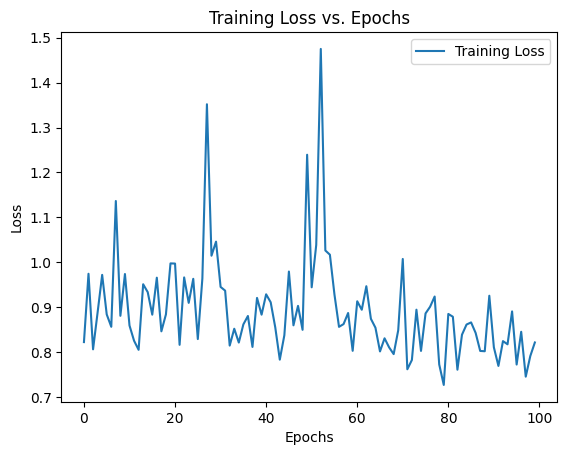

In [45]:
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epochs')
plt.legend()
plt.show()

Save the weights :

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
torch.save(model.state_dict(), '/content/model_weights.pth')

### **5.5. Evaluate the model**

#### **5.5.1. Compute the average loss on test data**

In [46]:
model.eval()
total_mse_loss = 0.0
total_mae_loss = 0.0

with torch.no_grad():
  for data, target in zip(test_data, test_targets):
    data = data.to(device)
    target = target.to(device)
    outputs = model(data)

    if target.dim() == 0:
        target = target.expand_as(outputs)

    mse_loss = F.mse_loss(outputs, target)
    mae_loss = F.l1_loss(outputs, target)

    total_mse_loss += mse_loss.item()
    total_mae_loss += mae_loss.item()

  avg_mse_loss = total_mse_loss / len(test_data)
  avg_mae_loss = total_mae_loss / len(test_data)
  print(f"Average MSE Loss on Test Data: {avg_mse_loss}")
  print(f"Average MAE Loss on Test Data: {avg_mae_loss}")

Average MSE Loss on Test Data: 1.0215481704553577
Average MAE Loss on Test Data: 0.7726897170449969


#### **5.5.2. Display the predicted solubility vs ground truth**

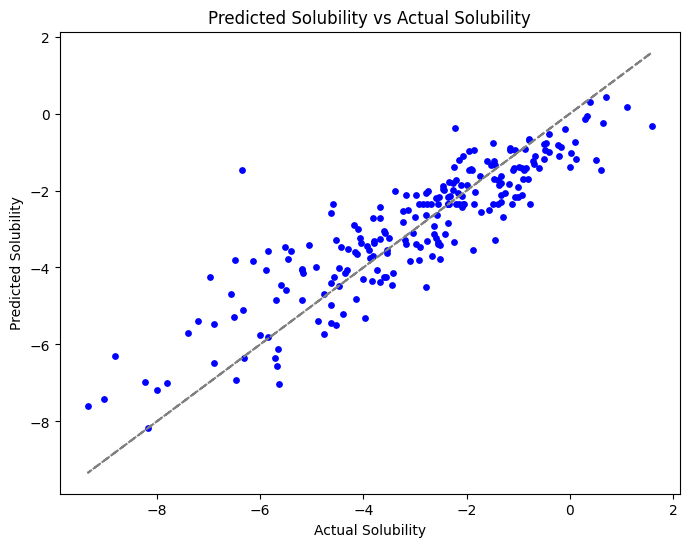

In [34]:
# Get predicted solubility values for test data
predicted_solubilities = []
with torch.no_grad():
    for data in test_data:
        outputs = model(data)
        predicted_solubilities.append(outputs.item())

# Convert predicted and actual solubility values to NumPy arrays for plotting
predicted_solubilities = np.array(predicted_solubilities)
actual_solubilities = test_targets.numpy()

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(actual_solubilities, predicted_solubilities, color='blue', s=15)
plt.title('Predicted Solubility vs Actual Solubility')
plt.xlabel('Actual Solubility')
plt.ylabel('Predicted Solubility')

plt.plot(actual_solubilities, actual_solubilities, color='gray', linestyle='--')

plt.grid(False)
plt.show()

#### **5.5.3. Results of the previous paper**

##### **Average Loss**

In [42]:
predicted_solubility = sol['ESOL predicted log(solubility:mol/L)']
measured_solubility = sol['measured log(solubility:mol/L)']

mse_loss = mean_squared_error(measured_solubility, predicted_solubility)
mae_loss = mean_absolute_error(measured_solubility, predicted_solubility)

print("Mean Squared Error (MSE):", mse_loss)
print("Mean Absolute Error (MAE):", mae_loss)

Mean Squared Error (MSE): 0.8217520533216783
Mean Absolute Error (MAE): 0.6944676573426574


##### **Predicted solubility vs ground truth**

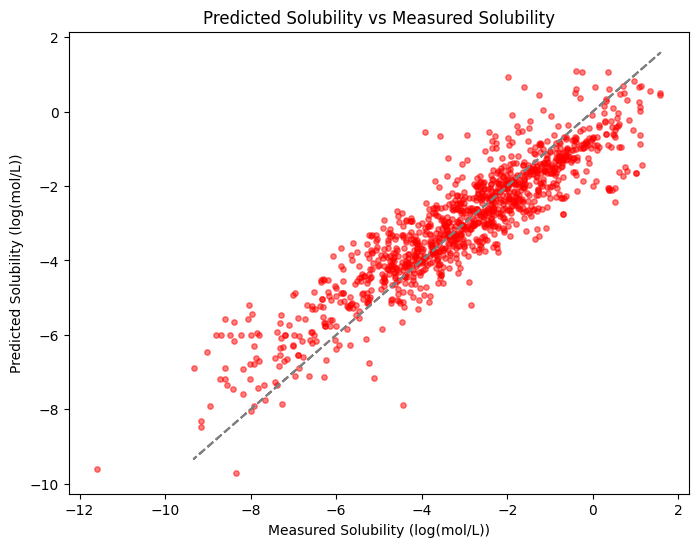

In [43]:
plt.figure(figsize=(8, 6))
plt.scatter(measured_solubility, predicted_solubility, color='red', alpha=0.5, s=15)
plt.title('Predicted Solubility vs Measured Solubility')
plt.xlabel('Measured Solubility (log(mol/L))')
plt.ylabel('Predicted Solubility (log(mol/L))')

plt.plot(actual_solubilities, actual_solubilities, color='gray', linestyle='--')

plt.grid(False)
plt.show()